In [12]:
import pandas as pd
import numpy as np
from model import HulaHoopLSTM
import torch
import matplotlib.pyplot as plt
# ! pip install scikit-learn
from sklearn.preprocessing import StandardScaler, MinMaxScaler



In [100]:

input_data_file = '/Users/jonaheaton/Documents/hulahoop_data/output_DSC_7450_hula_hoop_data.csv'
df = pd.read_csv(input_data_file)

In [102]:
df.columns

Index(['frame', 'top ellipse X', 'top ellipse Y', 'top ellipse Major Axis',
       'top ellipse Minor Axis', 'top ellipse Angle', 'bottom ellipse X',
       'bottom ellipse Y', 'bottom ellipse Major Axis',
       'bottom ellipse Minor Axis', 'bottom ellipse Angle'],
      dtype='object')

In [121]:

input_data_file = '/Users/jonaheaton/Documents/hulahoop_data/output_DSC_7450_hula_hoop_data.csv'
df = pd.read_csv(input_data_file)

coor_vars = ['top ellipse X','top ellipse Y','bottom ellipse X','bottom ellipse Y']

axis_vars = ['top ellipse Major Axis','top ellipse Minor Axis','bottom ellipse Major Axis','bottom ellipse Minor Axis']

angle_vars  = ['top ellipse Angle','bottom ellipse Angle']

df =df[coor_vars + axis_vars + angle_vars]

# look for outliers and replace them with the average of the previous and next values
for col in df.columns:
    outlier_th = df[col].quantile(0.95) - df[col].quantile(0.05)
    print(outlier_th)
    # if col in coor_vars:
    #     outlier_th = 1000
    # elif col in axis_vars:
    #     outlier_th = 1000
    # elif col in angle_vars:
    #     outlier_th = 200
    df[col] = df[col].mask((df[col].diff().abs() > outlier_th) & (df[col].diff(-1).abs() > outlier_th), np.nan)
    print(col, df[col].isna().sum())
    df[col] = df[col].fillna((df[col].shift(1) + df[col].shift(-1))/2)

        

246.6328384399414
top ellipse X 0
81.65944976806634
top ellipse Y 1
167.4179260253906
bottom ellipse X 0
161.82561225891118
bottom ellipse Y 0
78.63857440948485
top ellipse Major Axis 1
122.63086929321284
top ellipse Minor Axis 1
32.50699386596682
bottom ellipse Major Axis 0
40.68962020874022
bottom ellipse Minor Axis 0
12.239754486083982
top ellipse Angle 1
72.2077787399292
bottom ellipse Angle 0


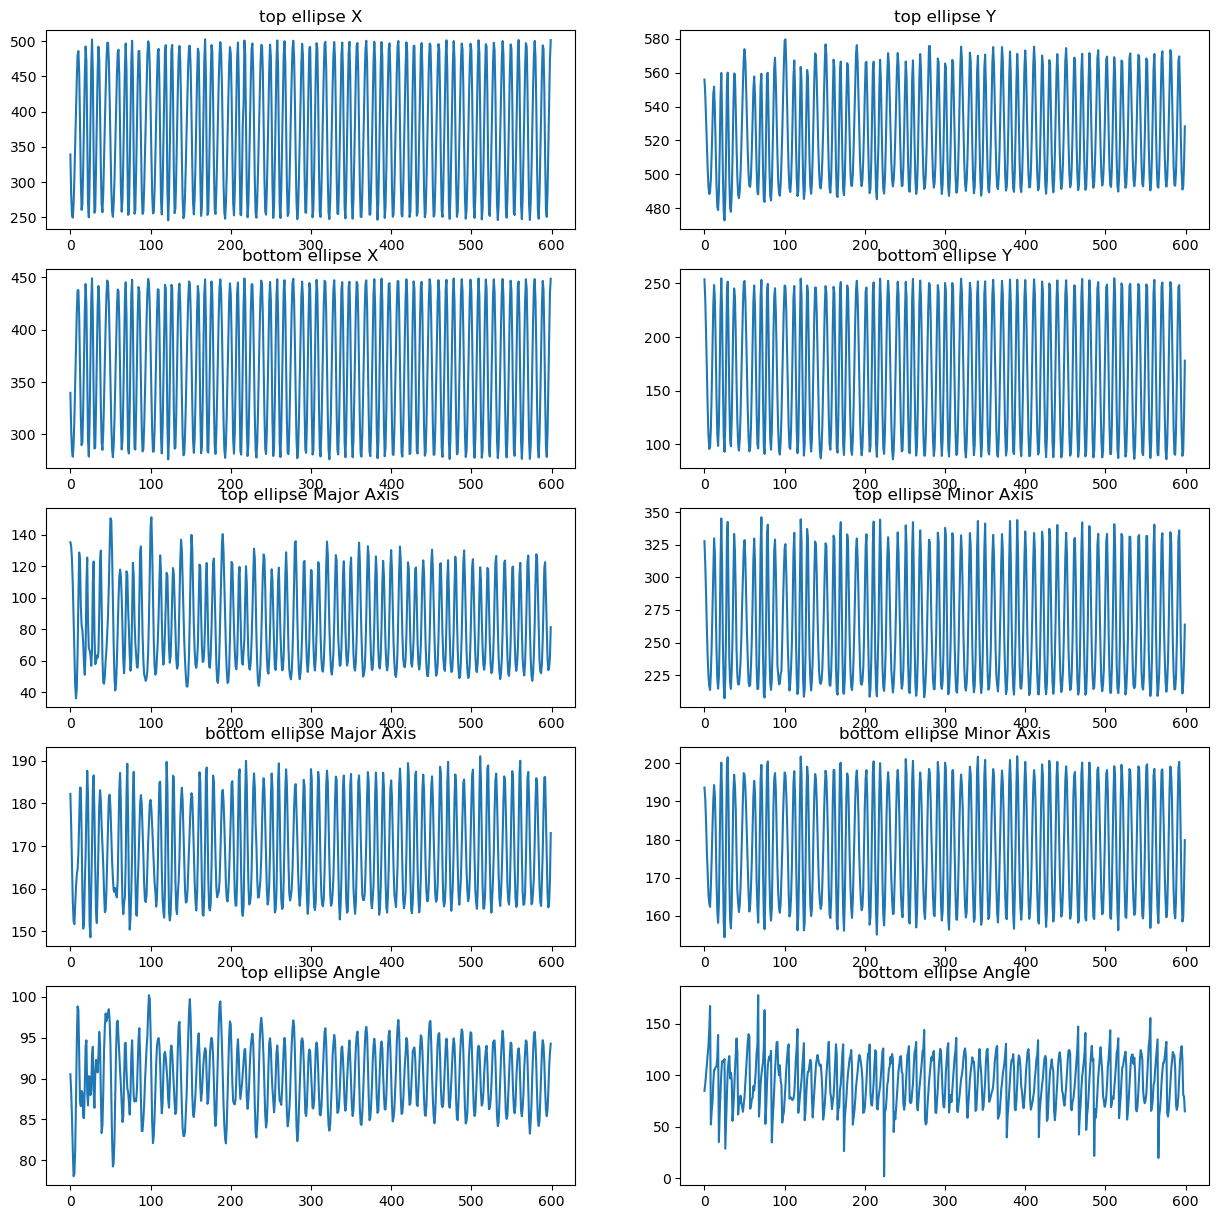

In [122]:
# plot the data
fig, axs = plt.subplots(5, 2, figsize=(15, 15))
for i, col in enumerate(df.columns):
    ax = axs[i//2, i%2]
    ax.plot(df[col])
    ax.set_title(col)
plt.show()

<Axes: >

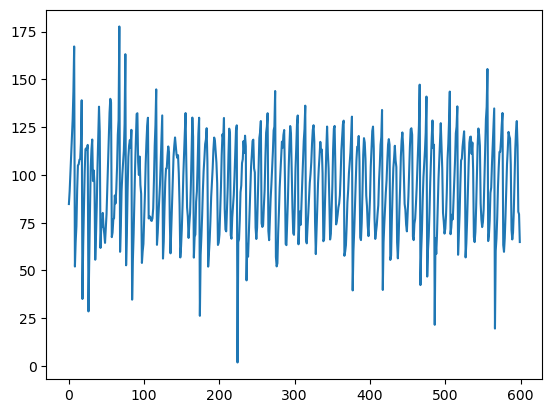

In [107]:
df['bottom ellipse Angle'].plot()

In [104]:
data = df.values

# Split the data into training and testing sets
train_size = int(0.8 * len(data))  # 80% for training, 20% for testing
train_data = data[:train_size,:]
test_data = data[train_size:,:]

In [105]:
def create_sequences(data, timesteps):
    X = []
    y = []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps,:])
        y.append(data[i+timesteps,:])
    return np.array(X), np.array(y)

timesteps = 1  # Number of previous time steps to use as input


In [73]:
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)


In [74]:
train_data

array([[-0.38546462,  1.0829075 , -0.38480613,  1.52787323],
       [-1.01929359,  0.77283202, -0.95964374,  1.20052442],
       [-1.35950224,  0.25851493, -1.31195406,  0.65704693],
       ...,
       [ 1.09714548, -0.65931516,  1.20537311, -0.72035636],
       [ 1.44195951,  0.14038327,  1.44838152,  0.16469495],
       [ 1.15776376,  1.07474573,  1.05825557,  1.06089097]])

In [75]:
X_train, y_train = create_sequences(train_data, timesteps)
X_test, y_test = create_sequences(test_data, timesteps)

In [76]:
# X_train_unscaled = scaler.inverse_transform(X_train.reshape(X_train.shape[0], -1))
y_train_unscaled = scaler.inverse_transform(y_train)
# X_test_unscaled = scaler.inverse_transform(X_test.reshape(X_test.shape[0], -1))
y_test_unscaled = scaler.inverse_transform(y_test)


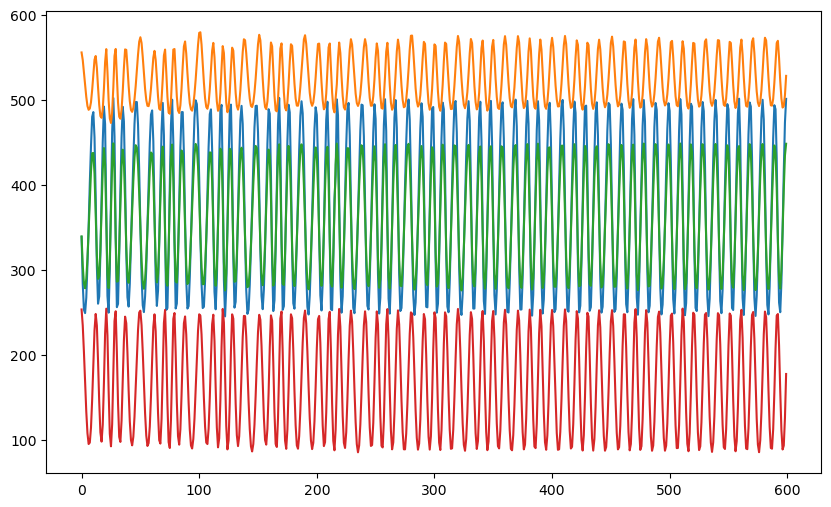

In [77]:

plt.figure(figsize=(10, 6))
plt.plot(data[:, 0], label='top ellipse X')
plt.plot(data[:, 1], label='top ellipse Y')
plt.plot(data[:, 2], label='bottom ellipse X')
plt.plot(data[:, 3], label='bottom ellipse Y')


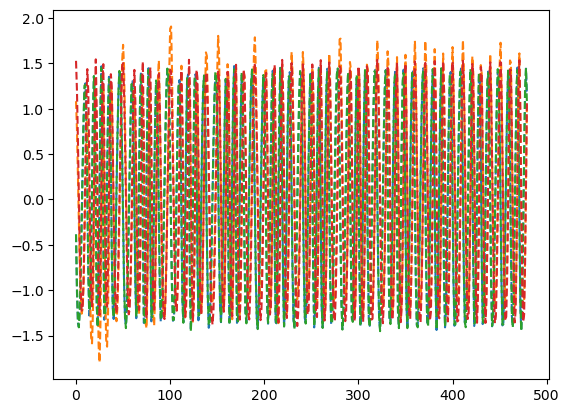

In [78]:
plt.plot(train_data[:,0], label='train top ellipse X', linestyle='dashed')
plt.plot(train_data[:,1], label='train top ellipse Y', linestyle='dashed')
plt.plot(train_data[:,2], label='train bottom ellipse X', linestyle='dashed')
plt.plot(train_data[:,3], label='train bottom ellipse Y', linestyle='dashed')

In [79]:
model = HulaHoopLSTM(input_size=4, hidden_size=32, output_size=4, num_layers=2)

In [80]:
model.fit(X_train, y_train, num_epoch=100, batch_size=16)

Epoch 0:	 loss=0.9925
Epoch 10:	 loss=0.0161
Epoch 20:	 loss=0.0153
Epoch 30:	 loss=0.0147
Epoch 40:	 loss=0.0145
Epoch 50:	 loss=0.0137
Epoch 60:	 loss=0.0133
Epoch 70:	 loss=0.0130
Epoch 80:	 loss=0.0122
Epoch 90:	 loss=0.0117


In [81]:
# plot the predictions
y_pred = model.predict(X_test)
# y_pred = scaler.inverse_transform(y_pred)
# y_test = scaler.inverse_transform(y_test)

In [82]:
y_pred_unscaled = scaler.inverse_transform(y_pred)


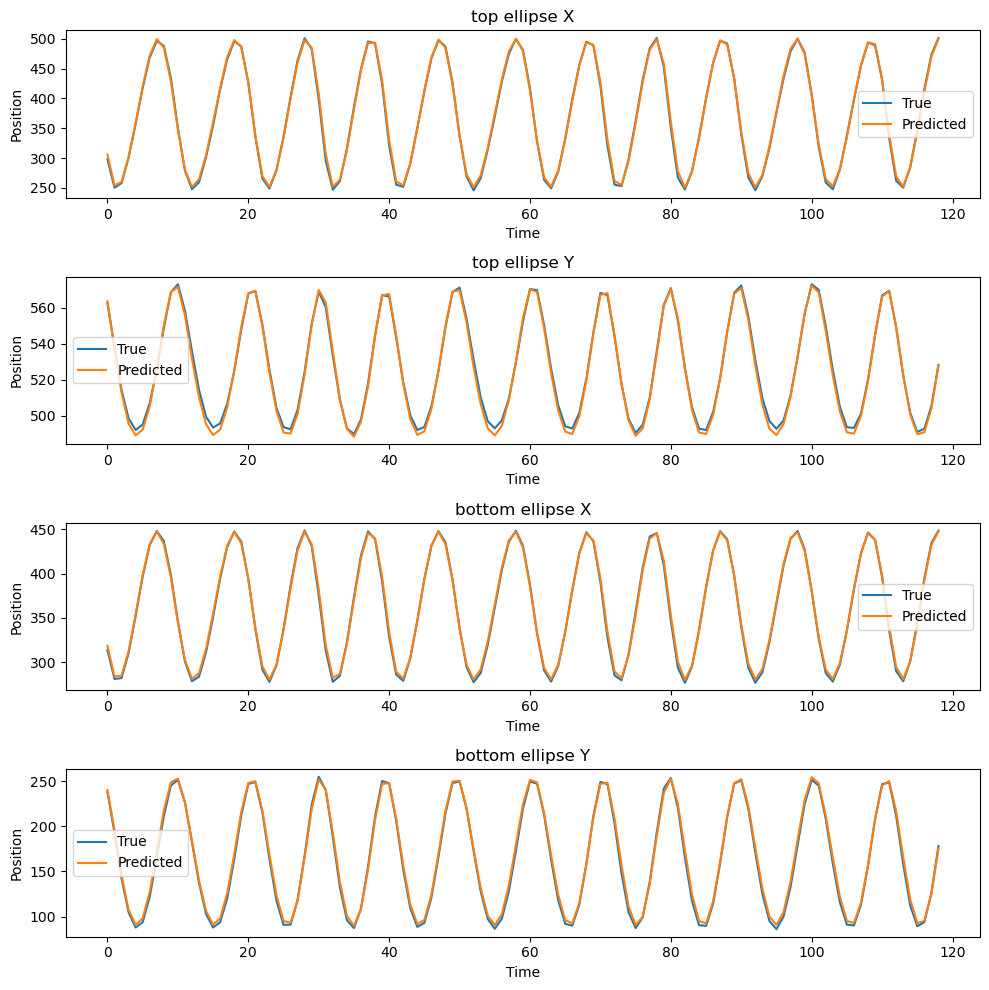

In [83]:
diff = y_test_unscaled - y_pred_unscaled

# make four subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 10))
for i in range(4):
    axs[i].plot(y_test_unscaled[:, i], label='True')
    axs[i].plot(y_pred_unscaled[:, i], label='Predicted')
    axs[i].legend()
    axs[i].set_title(f'{df.columns[i]}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Position')
plt.tight_layout()
plt.show()



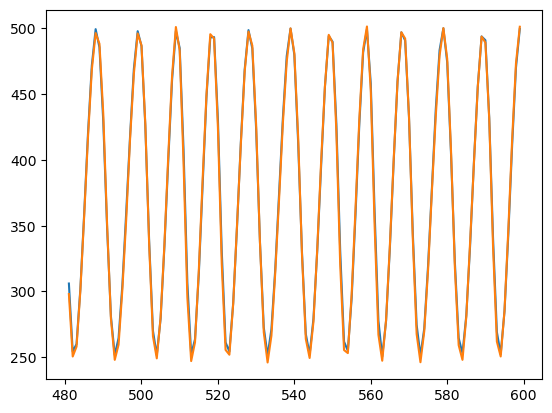

In [84]:
plt.plot(range(train_size + timesteps, len(data)), y_pred_unscaled[:, 0], label='Predicted top ellipse X')
plt.plot(range(train_size + timesteps, len(data)), y_test_unscaled[:, 0], label='Actual top ellipse X')


In [86]:
lstm = torch.nn.LSTM(input_size=4, 
                            hidden_size=8, 
                            num_layers=2, 
                            batch_first=True)

In [92]:
timesteps = 3
X_train, y_train = create_sequences(train_data, timesteps)
X_test, y_test = create_sequences(test_data, timesteps)

In [93]:
X_train.shape

(477, 3, 4)

In [94]:
in_tensor = torch.tensor(X_train[0,:,:]).float()
out = lstm(in_tensor)

In [95]:
in_tensor.shape

torch.Size([3, 4])

In [96]:
in_tensor

tensor([[-0.3855,  1.0829, -0.3848,  1.5279],
        [-1.0193,  0.7728, -0.9596,  1.2005],
        [-1.3595,  0.2585, -1.3120,  0.6570]])

In [98]:
out

(tensor([[ 0.0037,  0.0594, -0.0396, -0.0721,  0.0536,  0.0647, -0.1024,  0.0137],
         [ 0.0172,  0.0615, -0.0735, -0.1297,  0.0977,  0.0592, -0.1353,  0.0128],
         [ 0.0291,  0.0543, -0.0900, -0.1737,  0.1393,  0.0511, -0.1515,  0.0056]],
        grad_fn=<SqueezeBackward1>),
 (tensor([[ 0.2318,  0.1060,  0.2795, -0.2732, -0.2174, -0.0040, -0.2422, -0.1858],
          [ 0.0291,  0.0543, -0.0900, -0.1737,  0.1393,  0.0511, -0.1515,  0.0056]],
         grad_fn=<SqueezeBackward1>),
  tensor([[ 0.5715,  0.3284,  0.6244, -0.5429, -0.4435, -0.0070, -0.5858, -0.3014],
          [ 0.0546,  0.1112, -0.1744, -0.4838,  0.2582,  0.0908, -0.4877,  0.0138]],
         grad_fn=<SqueezeBackward1>)))